In [30]:
contributor = "Nada"

#### Step 1: Import Libraries

In [17]:
import json
import numpy as np
import pandas as pd
import csv
from datetime import datetime
import os
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go
from pandarallel import pandarallel
import matplotlib.pyplot as plt
pandarallel.initialize(progress_bar=True)
import pytz

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


#### Step 2: Load and Preprocess Data

In [2]:
# # Load the JSON file
# data = []
# with open('clean_trips.json', 'r') as file:
#     for line in file:
#         data.append(json.loads(line))

# df = pd.DataFrame(data)

# # Calculate trip time in seconds
# df['trip_time'] = df['time']

# # Drop rows with missing values (if any)
# df.dropna(inplace=True)

In [14]:
# Directory and file name pattern
directory = 'Cleaning/trial_week/clean_data'
file_base = 'clean_2024-01-'


# Generate the list of file names
files_names = [f'{file_base}{i}.json' for i in range(28, 32)]

# Generate the list of file directories
files = [os.path.join(directory, file_name) for file_name in files_names]

data = []

In [ ]:
# Load data from each JSON file
for file_name in files:
    with open(file_name, 'r') as file:
        for line in file:
            data.append(json.loads(line))

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate trip time in seconds
df['trip_time'] = df['time']

# Drop rows with missing values (if any)
df.dropna(inplace=True)

#### Step 3: Prepare Features and Target

In [5]:
# Feature extraction functions
def extract_features(row):
    features = {}
    features['mean_time_gap'] = np.mean(row['time_gap'])
    features['std_time_gap'] = np.std(row['time_gap'])
    features['min_time_gap'] = np.min(row['time_gap'])
    features['max_time_gap'] = np.max(row['time_gap'])
    
    features['mean_lat'] = np.mean(row['lats'])
    features['std_lat'] = np.std(row['lats'])
    features['min_lat'] = np.min(row['lats'])
    features['max_lat'] = np.max(row['lats'])
    
    features['mean_lng'] = np.mean(row['lngs'])
    features['std_lng'] = np.std(row['lngs'])
    features['min_lng'] = np.min(row['lngs'])
    features['max_lng'] = np.max(row['lngs'])
    
    features['mean_dist_gap'] = np.mean(row['dist_gap'])
    features['std_dist_gap'] = np.std(row['dist_gap'])
    features['min_dist_gap'] = np.min(row['dist_gap'])
    features['max_dist_gap'] = np.max(row['dist_gap'])
    
    return pd.Series(features)

#### Step 4: Split the Data

In [6]:
# Split the data
# X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=None)

# Apply feature extraction to each subset
train_features = X_train.apply(extract_features, axis=1)
test_features = X_test.apply(extract_features, axis=1)

# Combine features with other relevant columns
X_train = pd.concat([train_features, X_train[['driverID', 'weekID', 'timeID', 'dateID', 'trip_time']]], axis=1)
X_test = pd.concat([test_features, X_test[['driverID', 'weekID', 'timeID', 'dateID', 'trip_time']]], axis=1)

# Convert non-numeric columns to numeric or drop them
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])
X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])

# Ensure all features are numeric
assert X_train.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_train"
assert X_test.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_test"

#### Step 5: Hyperparameter Tuning and Model Training

##### Parameter Grid Search

In [7]:
# param_grid = {
#     'n_estimators': list(range(1, 202, 50)),
#     'max_depth': list(range(1, 8)),
#     'min_samples_leaf': list(range(1, 10)),
#     'max_leaf_nodes': [None] + list(range(10, 20, 2)),
#     'random_state': [42],
#     'criterion': ['squared_error', 'absolute_error']
# }

# grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring='neg_root_mean_squared_error')
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# model = RandomForestRegressor(**best_params)
# model.fit(X_train, y_train)

##### Narrow down the parameter grid search

##### Only one parameter

In [8]:
# Recommended initial hyperparameter values
n_estimators = 300
max_depth = None  # Let the tree grow until all leaves are pure or until they contain less than min_samples_split samples
min_samples_leaf = 3  # The minimum number of samples required to be at a leaf node
max_leaf_nodes = None  # Let the trees grow until all leaves are pure or until they contain less than min_samples_split samples
random_state = 42  # Ensures reproducibility
criterion = 'squared_error'  # Default criterion for regression tasks
max_features = 'sqrt'  # Consider sqrt of the number of features for each split

# Initialize and train the model with the recommended values
model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    max_leaf_nodes=max_leaf_nodes,
    random_state=random_state,
    criterion=criterion,
    max_features=max_features
)

model.fit(X_train.drop(columns=['trip_time']), y_train)

# Evaluate the model
y_pred = model.predict(X_test.drop(columns=['trip_time']))
mse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 12.340892624013795


C:\Users\nadab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Step 6: Evaluate the Model with Learning Curves

In [26]:
# Get current timestamp in Cairo time
cairo_tz = pytz.timezone('Africa/Cairo')
timestamp = datetime.now(cairo_tz).strftime('%Y-%m-%dT%H:%M:%S')

# Generate a unique label based on the timestamp
label = 'Model_Run_' + timestamp.replace(':', '').replace('-', '').split('.')[0]
# label = 'Model_Run_' + datetime.now().strftime("%Y%m%d_%H%M%S")

print(timestamp)
print(label)

2024-06-29T15:35:49
Model_Run_20240629T153549


In [9]:
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train.drop(columns=['trip_time']), y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5, scoring='neg_root_mean_squared_error')


fig = go.Figure()
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(train_scores, axis=1), name='Training error'))
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(valid_scores, axis=1), name='Validation error'))
fig.update_layout(
    title='Learning Curve: ' + label,
    xaxis_title='Number of Training Examples',
    yaxis_title='Root Mean Squared Error (RMSE)',
    legend_title='Error Type'
)
fig.show()

# Specify the directory and file name
output_directory = 'Careem_RFR_Figures/'  # Replace with your directory path
if not os.path.exists(output_directory):
    os.makedirs(output_directory)  # Create the directory if it doesn't exist
output_file = os.path.join(output_directory, f'learning_curve_{label}.png')

# Save the figure
fig.write_image(output_file)

#### Step 7: Make Predictions and Calculate Errors

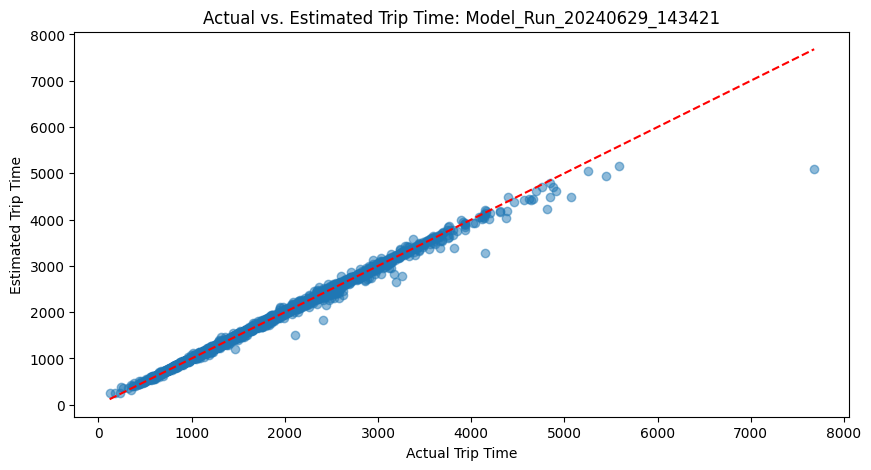

Mean Absolute Error (MAE): 18.31687753154951
R^2 Score: 0.9943069650654872


In [12]:
def estimations(test_data, model, feature_names):
    features_data = test_data[feature_names]
    test_data['trip_time_estimate'] = model.predict(features_data)
    test_data['error'] = test_data['trip_time'] - test_data['trip_time_estimate']
    test_data = test_data.query("error < 3600")
    return test_data

# Get the feature names used during training
feature_names = X_train.drop(columns=['trip_time']).columns.tolist()

def plot_graphs(plot_df):
    plt.figure(figsize=(10, 5))
    plt.scatter(plot_df['trip_time'], plot_df['trip_time_estimate'], alpha=0.5)
    plt.plot([plot_df['trip_time'].min(), plot_df['trip_time'].max()], 
             [plot_df['trip_time'].min(), plot_df['trip_time'].max()], 'r--')
    plt.xlabel('Actual Trip Time')
    plt.ylabel('Estimated Trip Time')
    plt.title('Actual vs. Estimated Trip Time: ' + label)
    plt.show()

    # Save the figure
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)  # Create the directory if it doesn't exist
    output_file = os.path.join(output_directory, f'actual_vs_estimated_{label}.png')
    plt.savefig(output_file)
    plt.close()

def get_metrics(plot_df):
    mae = mean_absolute_error(plot_df['trip_time'], plot_df['trip_time_estimate'])
    r2 = r2_score(plot_df['trip_time'], plot_df['trip_time_estimate'])
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')
    return mae, r2

# Assuming plot_df is defined from the previous estimations step
plot_df = estimations(X_test, model, feature_names)
plot_graphs(plot_df)
mae, r2 = get_metrics(plot_df)

#### Step 8: Log the results

In [31]:
# Define the log file path
log_file_path = 'model_training_results_log.csv'

# Create a log file with headers if it doesn't exist
if not os.path.exists(log_file_path):
    with open(log_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Timestamp', 'Label', 'n_estimators', 'max_depth', 'min_samples_leaf', 'max_leaf_nodes', 'random_state', 'criterion', 'max_features', 'RMSE', 'MAE', 'R2_Score', 'Input_Data_Files', 'Contributor'])

def log_model_training(n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files):
    # Log details into CSV file
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, label, n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files, contributor])


# Example usage
RMSE = rmse
MAE = mae
R2_Score = r2
# Convert list of files to a comma-separated string
input_data_files = ', '.join(files_names)
# input_data_files = 'clean_2024-01-25.json, clean_2024-01-26.json, clean_2024-01-27.json, clean_2024-01-28.json, clean_2024-01-29.json'

log_model_training(n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files)
